## Практическая работа к уроку №6

1. Попробуйте обучить нейронную сеть U-Net на любом другом датасете. 
2. Опишите  результат. Что помогло повысить точность?

Выбранный датасет CamSeq 2007<br>
Содержит 101 пару фотографий.<br>
Количество классов: 32.<br>
Исходное разрешение фотографий (720, 960)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from PIL import Image
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


### Подготовка данных

In [3]:
!unzip -q /content/gdrive/MyDrive/GeekBrains/intro_NN/06_lesson/archive.zip -d camseq

#### Проверка лейблов

Разберемся какие классы есть в датасете по условию

In [3]:
from pprint import pprint

label_colors_file = '/content/camseq/label_colors.txt'

with open(label_colors_file) as f:
    lines = f.readlines()

label_color = {}

for line in lines:
    tmp = line.replace('\t', ' ').replace('\n', '').split(' ')
    label = tmp[-1]
    label_color[label] = list(map(int, tmp[:3]))

num_classes = len(label_color)
print(f"Всего классов: {num_classes}")

pprint(label_color)

Всего классов: 32
{'Animal': [64, 128, 64],
 'Archway': [192, 0, 128],
 'Bicyclist': [0, 128, 192],
 'Bridge': [0, 128, 64],
 'Building': [128, 0, 0],
 'Car': [64, 0, 128],
 'CartLuggagePram': [64, 0, 192],
 'Child': [192, 128, 64],
 'Column_Pole': [192, 192, 128],
 'Fence': [64, 64, 128],
 'LaneMkgsDriv': [128, 0, 192],
 'LaneMkgsNonDriv': [192, 0, 64],
 'Misc_Text': [128, 128, 64],
 'MotorcycleScooter': [192, 0, 192],
 'OtherMoving': [128, 64, 64],
 'ParkingBlock': [64, 192, 128],
 'Pedestrian': [64, 64, 0],
 'Road': [128, 64, 128],
 'RoadShoulder': [128, 128, 192],
 'SUVPickupTruck': [64, 128, 192],
 'Sidewalk': [0, 0, 192],
 'SignSymbol': [192, 128, 128],
 'Sky': [128, 128, 128],
 'TrafficCone': [0, 0, 64],
 'TrafficLight': [0, 64, 64],
 'Train': [192, 64, 128],
 'Tree': [128, 128, 0],
 'Truck_Bus': [192, 128, 192],
 'Tunnel': [64, 0, 64],
 'VegetationMisc': [192, 192, 0],
 'Void': [0, 0, 0],
 'Wall': [64, 192, 0]}


Прочтем все маски

In [4]:
DATA = "/content/camseq"

masks = []

new_size = (256, 256)

for filename in tqdm(list(glob.glob(f"{DATA}/*L.png"))):
    mask = Image.open(filename).convert('RGB')
    masks.append(np.array(mask))

100%|██████████| 101/101 [00:01<00:00, 83.72it/s]


Проверим все ли классы в действительности есть на фотографиях

In [5]:
keys_existing = set()

for mask in tqdm(masks):
    for key, color in label_color.items():
        if np.sum(np.all(mask==color, axis=-1)):
            # если такой цвет есть в маске, то добавляем ключ в set
            keys_existing.add(key)

pprint(keys_existing)

100%|██████████| 101/101 [01:16<00:00,  1.33it/s]

{'Archway',
 'Bicyclist',
 'Building',
 'Car',
 'CartLuggagePram',
 'Child',
 'Column_Pole',
 'Fence',
 'LaneMkgsDriv',
 'LaneMkgsNonDriv',
 'Misc_Text',
 'OtherMoving',
 'Pedestrian',
 'Road',
 'Sidewalk',
 'SignSymbol',
 'Sky',
 'TrafficLight',
 'Tree',
 'Truck_Bus',
 'VegetationMisc',
 'Void',
 'Wall'}


Оставим в label_color только существующие в масках объекты

In [6]:
for bad_color in list(set(label_color.keys()) - keys_existing):
    label_color.pop(bad_color)

num_classes = len(label_color)
print(f"Всего классов: {num_classes}")
pprint(label_color)

Всего классов: 23
{'Archway': [192, 0, 128],
 'Bicyclist': [0, 128, 192],
 'Building': [128, 0, 0],
 'Car': [64, 0, 128],
 'CartLuggagePram': [64, 0, 192],
 'Child': [192, 128, 64],
 'Column_Pole': [192, 192, 128],
 'Fence': [64, 64, 128],
 'LaneMkgsDriv': [128, 0, 192],
 'LaneMkgsNonDriv': [192, 0, 64],
 'Misc_Text': [128, 128, 64],
 'OtherMoving': [128, 64, 64],
 'Pedestrian': [64, 64, 0],
 'Road': [128, 64, 128],
 'Sidewalk': [0, 0, 192],
 'SignSymbol': [192, 128, 128],
 'Sky': [128, 128, 128],
 'TrafficLight': [0, 64, 64],
 'Tree': [128, 128, 0],
 'Truck_Bus': [192, 128, 192],
 'VegetationMisc': [192, 192, 0],
 'Void': [0, 0, 0],
 'Wall': [64, 192, 0]}


#### Предобработка фотографий и масок

In [7]:
def get_new_mask(mask):
    new_mask = np.zeros((mask.shape[0], mask.shape[1], num_classes), dtype=np.int64)
    for i, (key, color) in enumerate(label_color.items()):
        one_label_mask = np.all(mask==color, axis=-1) * 1
        new_mask[:,:,i] = one_label_mask
    return new_mask

In [8]:
DATA = "/content/camseq"
files = list(glob.glob(f"{DATA}/*.png"))
files.sort()
images = []
masks = []

new_size = (256, 256)

for filename in tqdm(files):
    name, ext = filename.split('.')
    if name.endswith('L'):
        mask = Image.open(filename).convert('RGB')
        mask = mask.resize(new_size)
        mask = np.array(mask)
        mask = get_new_mask(mask)
        masks.append(mask)
    else:
        image = Image.open(filename).convert('RGB')
        image = image.resize(new_size)
        image = np.array(image)
        image = image / 255
        images.append(image)

print(f'Всего пар изображений: {len(images)}')

100%|██████████| 202/202 [00:13<00:00, 15.38it/s]

Всего пар изображений: 101


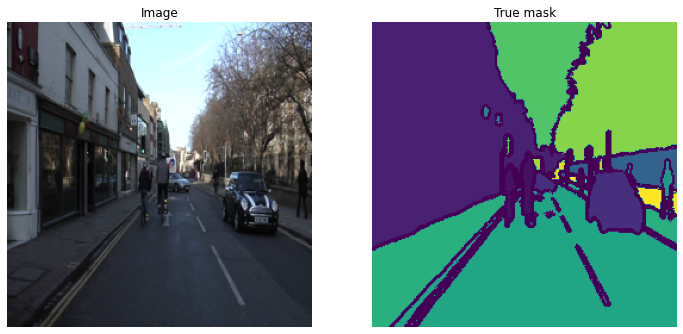

In [9]:
def mask_to_image(mask):
    new_mask = np.zeros((mask.shape[0], mask.shape[1]))
    for i in range(mask.shape[2]):
        new_mask += mask[:,:,i] * i
    return new_mask

def display_image_and_mask(image, mask):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))

    ax1.imshow(image)
    ax1.set_title('Image')
    ax2.imshow(mask_to_image(mask))
    ax2.set_title('True mask')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()

def display_image_mask_pred(image, mask, pred):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 12))

    ax1.imshow(image)
    ax1.set_title('Image')
    ax2.imshow(mask_to_image(mask))
    ax2.set_title('True mask')
    ax3.imshow(mask_to_image(pred))
    ax3.set_title('Predicted mask')
    ax1.axis('off')
    ax2.axis('off')
    ax3.axis('off')
    plt.show()

display_image_and_mask(images[0], masks[0])

Разделим данные на обучающую и тестовую выборки в соотношении 85 на 15

In [11]:
border = 85
train_images = np.array(images[:border])
train_masks = np.array(masks[:border])
val_images = np.array(images[border:])
val_masks = np.array(masks[border:])

#### Кастомный генератор с аугментациями

In [12]:
import albumentations as A

In [13]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, masks, batch_size, augmentation=False):
        self.images = images
        self.masks = masks
        self.batch_size = batch_size
        self.augmentation = augmentation

        self.indices = np.arange(len(self.images))
        self.dataset_len = len(self.images) // self.batch_size
        self.image_dim = images[0].shape
        self.masks_dim = masks[0].shape

        self.transform = A.Compose([
                                    A.HorizontalFlip(),
                                    A.Rotate(limit=15)
        ])

    def __len__(self):
        return self.dataset_len

    def augment(self, image, mask):
        transformed = self.transform(image=image, mask=mask)
        return transformed['image'], transformed['mask']
    
    def __getitem__(self, index):
        batch_idx = self.indices[index*self.batch_size : (index+1)*self.batch_size]

        Data   = np.empty((self.batch_size, *self.image_dim), dtype=np.float32)
        Target = np.empty((self.batch_size, *self.masks_dim),  dtype=np.uint8)

        for i, idx in enumerate(batch_idx):
            x = self.images[idx]
            y = self.masks[idx]

            if self.augmentation:
                x, y = self.augment(x, y)
            
            Data[i,] = x
            Target[i,] = y
        
        return Data, Target

In [14]:
train_generator = DataGenerator(train_images, train_masks,
                                batch_size=8, augmentation=True)
val_generator = DataGenerator(val_images, val_masks,
                              batch_size=8, augmentation=False)

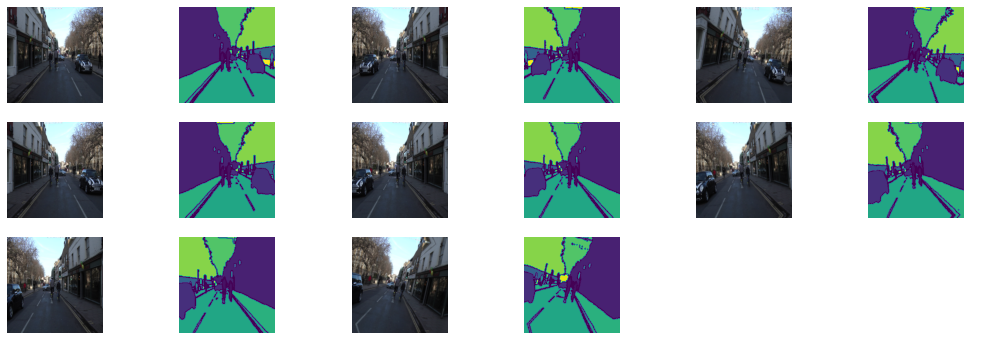

In [15]:
x, y = next(iter(train_generator))
num_examples = len(x)
column_pairs = 3

fig, axes = plt.subplots(int(np.ceil(num_examples / column_pairs)), column_pairs*2,
                         figsize=(18, 6))
axes = axes.flatten()

for ax in axes:
    ax.axis('off')

for i, (image, mask) in enumerate(zip(x, y)):
    axes[i*2].imshow(image)
    axes[i*2+1].imshow(mask_to_image(mask))
plt.show()

### Unet model

In [16]:
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

In [17]:
def down_block(input, filters, level):
    x = Conv2D(filters, (3, 3), padding='same', name=f'{level}_down_conv1')(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, (3, 3), padding='same', name=f'{level}_down_conv2')(x)
    x = BatchNormalization()(x)
    out = Activation('relu')(x)
    x = MaxPooling2D()(out)
    return x, out

def up_block(input, prev_layer, filters, level):
    x = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(input)
    # x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # skip connection
    x = concatenate([x, prev_layer])
    x = Conv2D(filters, (3, 3), padding='same', name=f'{level}_up_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name=f'{level}_up_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def bottle_neck(input, filters):
    x = Conv2D(filters, (3, 3), padding='same')(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters * 2, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def unet_model():
    img_input = Input(train_images[0].shape)
    # down
    x, block1_out = down_block(img_input, 64, 'block1') # 256 -> 128
    x, block2_out = down_block(x, 128, 'block2') # 128 -> 64
    x, block3_out = down_block(x, 256, 'block3') # 64 -> 32
    x, block4_out = down_block(x, 512, 'block4') # 32 -> 16
    # bottle neck
    # x = bottle_neck(x, 512)
    # up
    x = up_block(x, block4_out, 512, 'block4') # 16 -> 32
    x = up_block(x, block3_out, 256, 'block3') # 32 -> 64
    x = up_block(x, block2_out, 128, 'block2') # 64 -> 128
    x = up_block(x, block1_out, 64, 'block1') # 128 -> 256
    # final layer - conv2d
    out = Conv2D(num_classes, (1, 1), activation='softmax', padding='same')(x)

    model = Model(img_input, out)

    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model

In [18]:
unet = unet_model()

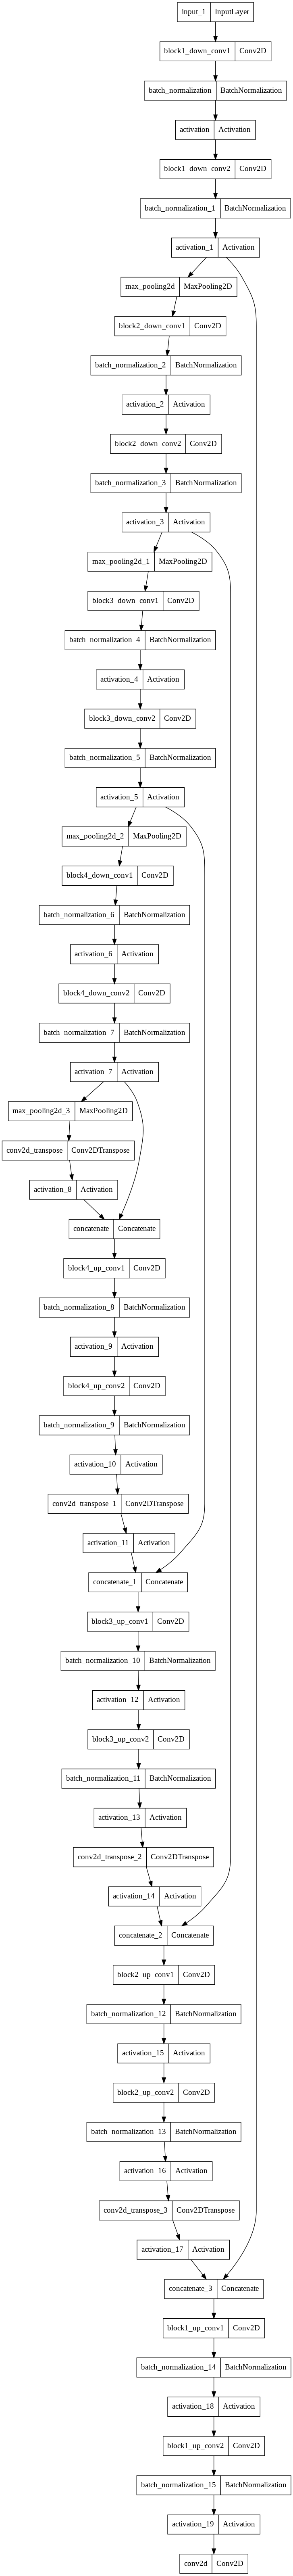

In [19]:
plot_model(unet, 'unet.png')

In [20]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_down_conv1 (Conv2D)     (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['block1_down_conv1[0][0]']      
 alization)                     )                                                             

Будем уменьшать learning rate в зависимости от эпохи

In [21]:
start_lr = 0.001
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    elif 10 <= epoch < 20:
        return 0.0005 # start_lr / 2
    elif 20 <= epoch < 30:
        return 0.00025 # start_lr / 2 / 2
    else:
        return 0.0001 # start_lr / 2 / 2 / 2

In [22]:
cb = [
    #  callbacks.EarlyStopping(monitor='val_dice_coef', patience=10, verbose=0),
        callbacks.LearningRateScheduler(scheduler, verbose=0)
    ]

history = unet.fit(train_generator, validation_data=val_generator,
                   epochs=70,
                   callbacks=[cb])
train_logs = unet.evaluate(train_generator, verbose=0)
test_logs = unet.evaluate(val_generator, verbose=0)

Epoch 1/70
10/10 [==============================] - 29s 1s/step - loss: 1.4040 - dice_coef: 0.4012 - val_loss: 3.8328 - val_dice_coef: 0.0246 - lr: 0.0010
Epoch 2/70
10/10 [==============================] - 13s 1s/step - loss: 0.6397 - dice_coef: 0.6150 - val_loss: 18.9447 - val_dice_coef: 0.0923 - lr: 0.0010
Epoch 3/70
10/10 [==============================] - 13s 1s/step - loss: 0.5477 - dice_coef: 0.6398 - val_loss: 24.5962 - val_dice_coef: 0.1642 - lr: 0.0010
Epoch 4/70
10/10 [==============================] - 13s 1s/step - loss: 0.4709 - dice_coef: 0.6799 - val_loss: 23.4941 - val_dice_coef: 0.1867 - lr: 0.0010
Epoch 5/70
10/10 [==============================] - 13s 1s/step - loss: 0.4368 - dice_coef: 0.6972 - val_loss: 8.0810 - val_dice_coef: 0.2001 - lr: 0.0010
Epoch 6/70
10/10 [==============================] - 13s 1s/step - loss: 0.4311 - dice_coef: 0.6998 - val_loss: 3.0365 - val_dice_coef: 0.3135 - lr: 0.0010
Epoch 7/70
10/10 [==============================] - 13s 1s/step - l

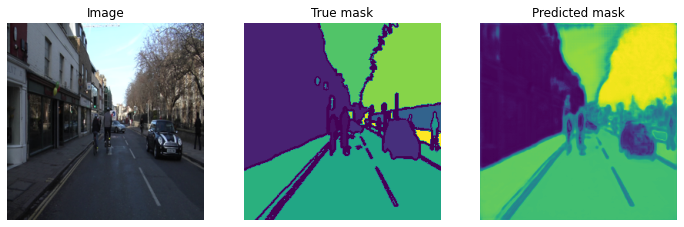

In [23]:
batch = next(iter(train_generator))
pred = unet.predict(batch[0])
display_image_mask_pred(batch[0][0], batch[1][0], pred[0])

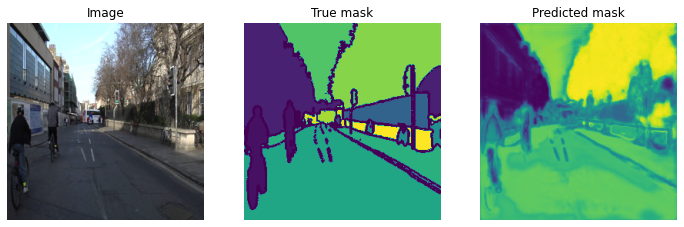

In [24]:
batch = next(iter(val_generator))
pred = unet.predict(batch[0])
display_image_mask_pred(batch[0][0], batch[1][0], pred[0])

In [25]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 5))

    ax1.plot(history['loss'], label='loss')
    ax1.plot(history['val_loss'], label='val_loss')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.legend()

    ax2.plot(history['dice_coef'], label='dice_coef')
    ax2.plot(history['val_dice_coef'], label='val_dice_coef')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('dice_coef')    
    ax2.legend()
    
    plt.show()

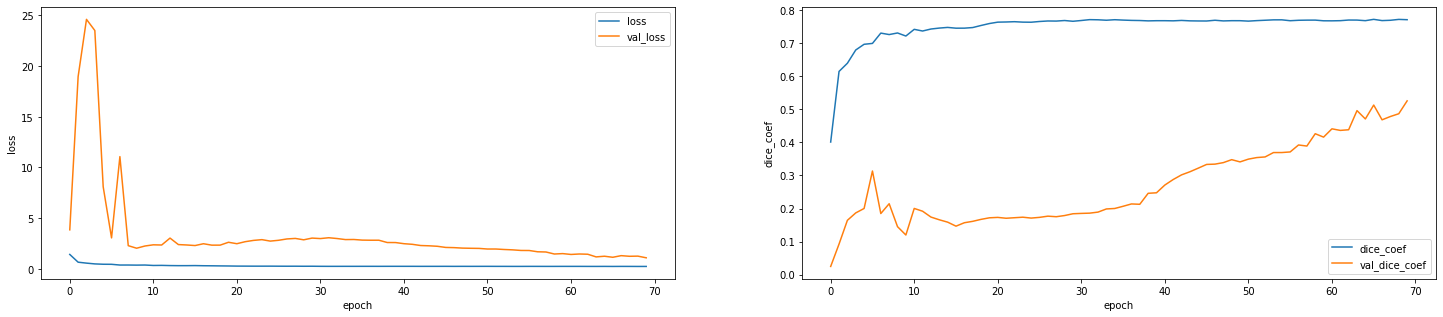

In [26]:
plot_history(history.history)